In [2]:
library('data.table')
library('extraDistr')
library('foreach')
library('khroma')

source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')

options(repr.plot.width=10*sqrt(2), repr.plot.height=10)

Train the agent

In [3]:
opmall <- buildagent(metadata='meta_income_data_example.csv',
                     data='train-income_data_example.csv')

## Calculating relevance of predictors

Mutual information between `income` and every variate used as single predictor

In [5]:
## list of all variates
variates <- names(dimnames(opmall$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'income']

## prepare named vector to contain all mutual informations
singleMIs <- numeric(length(predictors))
names(singleMIs) <- predictors

## calculate joint probability and then mutual information (in shannons)
## of 'income' and every other single variate
clock <- Sys.time() # let's check how long it takes
for(var in predictors){
    probs <- infer(agent=opmall, predictand=c('income',var))
    
    singleMIs[var] <- mutualinfo(probs=probs, A='income', B=var)
}
print(Sys.time()-clock)
cat('\n')

## output the mutual informations in decreasing order
print(round(sort(singleMIs, decreasing=TRUE), 4))

Time difference of 5.94567 secs

marital_status   relationship      education     occupation      workclass 
        0.1007         0.0905         0.0633         0.0551         0.0300 
native_country            sex           race 
        0.0193         0.0146         0.0087 


Mutal information between `income` and all other eight variates

In [6]:
variates <- names(dimnames(opmall$counts))

predictors <- variates[variates != 'income']

clock <- Sys.time()
probs <- infer(agent=opmall, predictand=c('income', predictors))

totalMI <- mutualinfo(probs=probs, A='income', B=predictors)
print(Sys.time()-clock)
cat('\n')

print(round(totalMI, 4))

Time difference of 3.99522 mins
[1] 0.4009


Mutal information between `income` and all other variates except for one. We keep out one variate in turn

In [14]:
variates <- names(dimnames(opmall$counts))

predictors <- variates[variates != 'income']

## "leave-one-out" Mutual Informations
looMIs <- numeric(length(predictors))
names(looMIs) <- predictors

clock <- Sys.time()
for(var in predictors){
    predictorsminusone <- predictors[predictors != var]
    probs <- infer(agent=opmall, predictand=c('income', predictorsminusone))

    looMIs[var] <- mutualinfo(probs=probs, A='income', B=predictorsminusone)
}
print(Sys.time()-clock)
cat('\n')


names(looMIs) <- paste0('omit.', predictors)
print(round(sort(looMIs, decreasing=FALSE), 4))

Time difference of 5.19242 mins

     omit.education     omit.occupation      omit.workclass omit.marital_status 
             0.3124              0.3249              0.3499              0.3792 
omit.native_country           omit.race   omit.relationship            omit.sex 
             0.3807              0.3827              0.3848              0.3899 


Print out all these mutual informations, in decreasing order

In [15]:
print(cbind(round(sort(c(singleMIs, all=totalMI, looMIs), decreasing=TRUE), 4)))

                      [,1]
all                 0.4009
omit.sex            0.3899
omit.relationship   0.3848
omit.race           0.3827
omit.native_country 0.3807
omit.marital_status 0.3792
omit.workclass      0.3499
omit.occupation     0.3249
omit.education      0.3124
marital_status      0.1007
relationship        0.0905
education           0.0633
occupation          0.0551
workclass           0.0300
native_country      0.0193
sex                 0.0146
race                0.0087


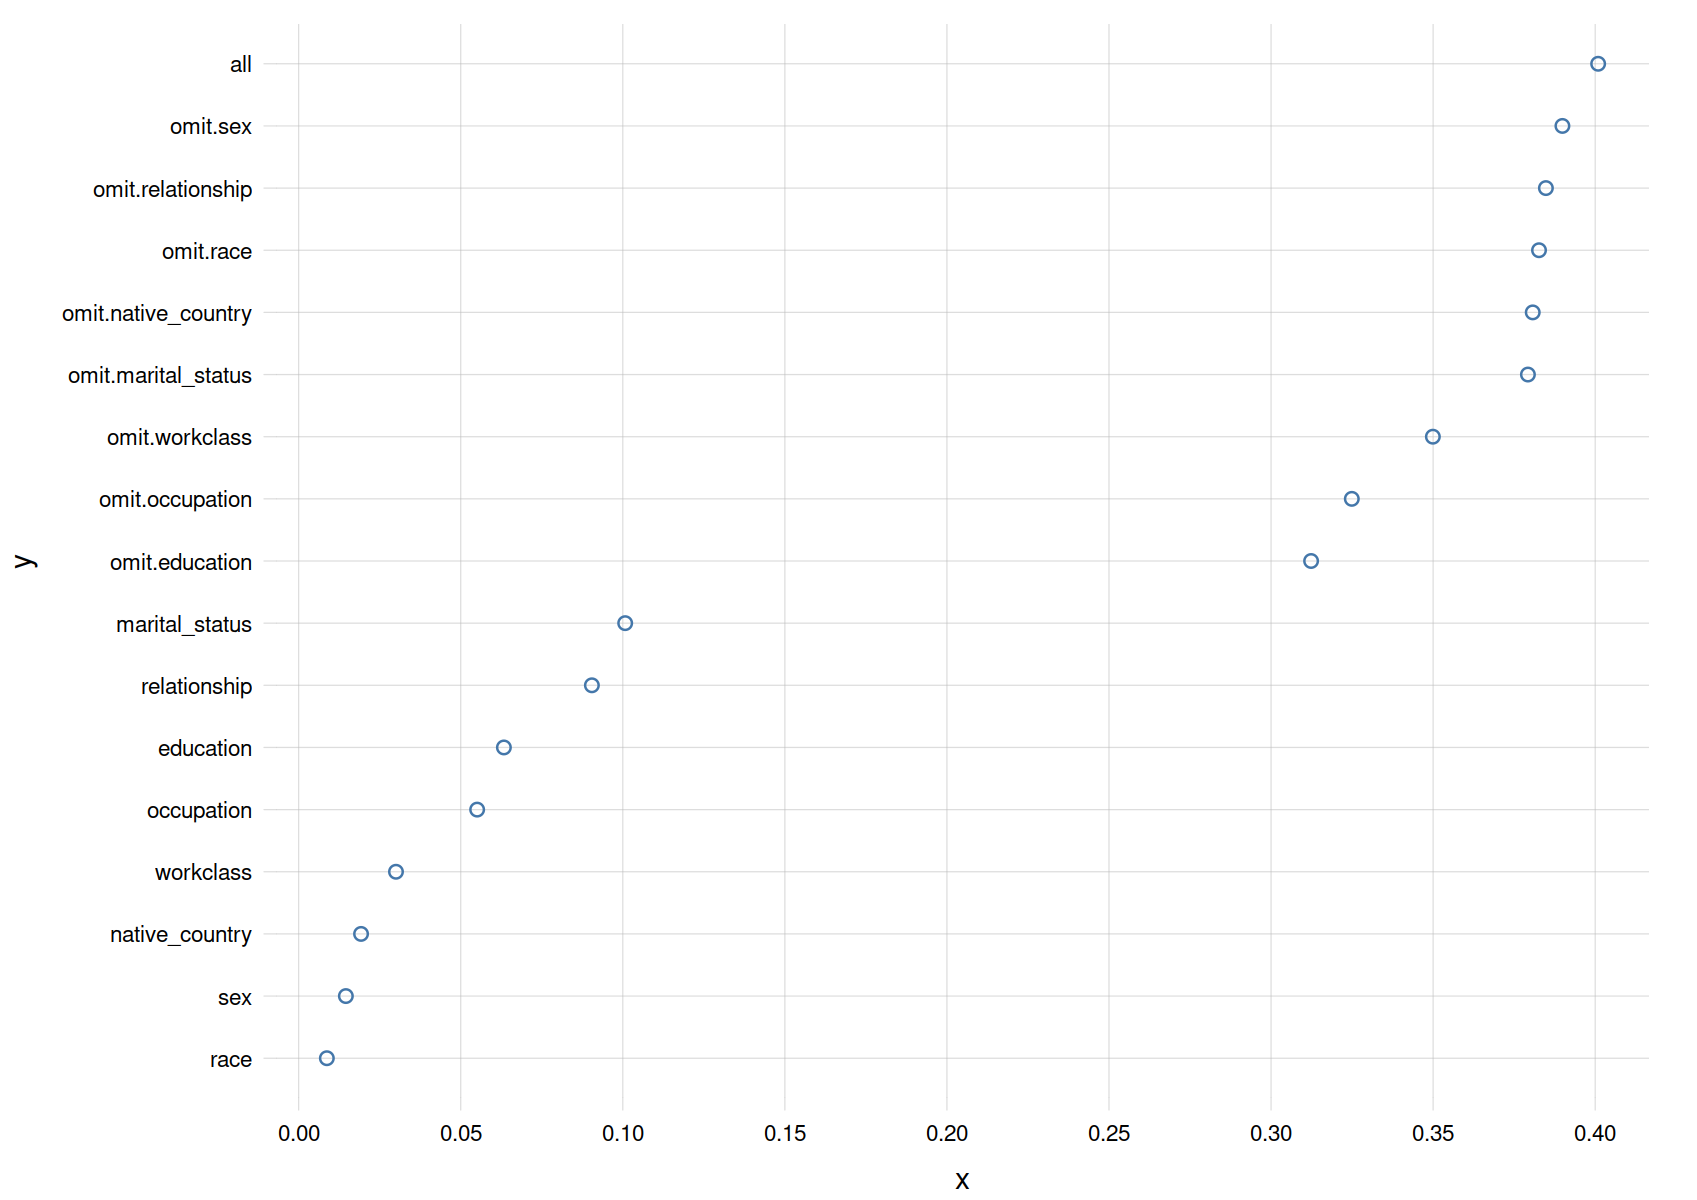

In [21]:
allMIs <- sort(c(singleMIs, all=totalMI, looMIs))

tplot(y=names(allMIs), x=allMIs, type='p', ly=10)